<a href="https://colab.research.google.com/github/DamnScallion/Visionary-Unicorns-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Have a second try

In [ ]:
!git clone https://github.com/DamnScallion/Visionary-Unicorns-Project.git

Cloning into 'Visionary-Unicorns-Project'...
remote: Enumerating objects: 601, done.
remote: Counting objects: 100% (601/601), done.
remote: Compressing objects: 100% (599/599), done.
remote: Total 601 (delta 8), reused 582 (delta 2), pack-reused 0
Receiving objects: 100% (601/601), 20.91 MiB | 29.09 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT_DIR = '/content/drive/My Drive/COMP9517/project'

In [ ]:
!pip install ultralytics

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd
import os
import shutil

In [ ]:
def yolo_dataset(src_dir, dest_dir):
  if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
  image_names = sorted(os.listdir(src_dir))
  for image_name in image_names:
    src_path = os.path.join(src_dir, image_name)
    dest_path = os.path.join(dest_dir, image_name)
    shutil.copyfile(src_path, dest_path)

In [ ]:
def yolo_labels(images_dir, orig_labels_dir, yolo_labels_dir):
  image_names = sorted(os.listdir(images_dir))
  train_labels = pd.read_json(orig_labels_dir)[['image_id', 'category_id', 'bbox']]

  if not os.path.exists(yolo_labels_dir):
    os.makedirs(yolo_labels_dir)

  for _, row in train_labels.iterrows():
    image_id, category_id, bbox = row['image_id'], row['category_id'], row['bbox']
    xmin, ymin, box_width, box_height = bbox
    xmin, ymin, box_width, box_height = int(xmin), int(ymin), int(box_width), int(box_height)
    xmax, ymax = (xmin + box_width, ymin + box_height)

    image_name = image_names[int(image_id)]
    curr_path = os.path.join(images_dir, image_name)
    image = cv2.imread(curr_path)
    image_width, image_height = image.shape[:2]

    x_center = (xmin + xmax) / (2 * image_width)
    y_center = (ymin + ymax) / (2 * image_height)
    box_width = box_width / image_width
    box_height = box_height / image_height

    yolo_label_format = f'{category_id} {x_center:.5f} {y_center:.5f} {box_width:.5f} {box_height:.5f}'

    label_file_name = str(image_name).replace('.jpg', '')

    label_path = os.path.join(yolo_labels_dir, label_file_name + '.txt')
    with open(label_path, 'w', encoding='utf8') as file:
      file.write(yolo_label_format)
      file.close()

In [ ]:
yolo_dataset(os.path.join(ROOT_DIR, 'archive/train/train/'), os.path.join(ROOT_DIR, 'data/images/train/'))

In [ ]:
yolo_dataset(os.path.join(ROOT_DIR, 'archive/valid/valid/'), os.path.join(ROOT_DIR, 'data/images/valid/'))

In [ ]:
yolo_labels(os.path.join(ROOT_DIR, 'archive/train/train/'), os.path.join(ROOT_DIR, 'archive/train_annotations'), os.path.join(ROOT_DIR, 'data/labels/train/'))

In [ ]:
yolo_labels(os.path.join(ROOT_DIR, 'archive/valid/valid/'), os.path.join(ROOT_DIR, 'archive/valid_annotations'), os.path.join(ROOT_DIR, 'data/labels/valid/'))

In [ ]:
# Create a new YOLO model from scratch
model = YOLO('yolov8n.yaml')

In [ ]:
# Train the model using the 'coco128.yaml' dataset for 100 epochs
results = model.train(data=os.path.join(ROOT_DIR, 'yolo_config.yaml'), epochs=100, imgsz=640)

Ultralytics YOLOv8.0.136 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/My Drive/COMP9517/project/yolo_config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!scp -r /content/runs '/content/drive/My Drive/COMP9517/project'

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
trained_model = YOLO(os.path.join(ROOT_DIR, 'runs/detect/train/weights/best.pt'))

In [ ]:
# Function to perform object detection
def detection(img_path, model):
  # Load image
  img = cv2.imread(img_path)

  # Perform object detection
  results = model.predict(source = img)

  # print(f'results = {results}')

  # Extract bounding boxes
  boxes = results[0].boxes
  print(f'boxes length = {len(boxes)}')

  bounding_boxes = []

  for box in boxes:
    left, top, right, bottom = box.xyxy[0]
    left, top, right, bottom = int(left), int(top), int(right), int(bottom)
    print(left, top, right, bottom)
    print(f'box = {box}')

    cls_id = int(list(box.cls)[0])

    print(f'cls_id = {cls_id}')

    bounding_boxes.append((left, top, right, bottom))

  return bounding_boxes


0: 640x640 1 penguin, 18.9ms
Speed: 2.8ms preprocess, 18.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


boxes length = 1
228 84 528 621
box = ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([[228.1733,  84.2933, 528.7181, 621.0717,   0.8853,   1.0000]], device='cuda:0')
cls: tensor([1.], device='cuda:0')
conf: tensor([0.8853], device='cuda:0')
data: tensor([[228.1733,  84.2933, 528.7181, 621.0717,   0.8853,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[378.4457, 352.6825, 300.5449, 536.7783]], device='cuda:0')
xywhn: tensor([[0.5913, 0.5511, 0.4696, 0.8387]], device='cuda:0')
xyxy: tensor([[228.1733,  84.2933, 528.7181, 621.0717]], device='cuda:0')
xyxyn: tensor([[0.3565, 0.1317, 0.8261, 0.9704]], device='cuda:0')
cls_id = 1


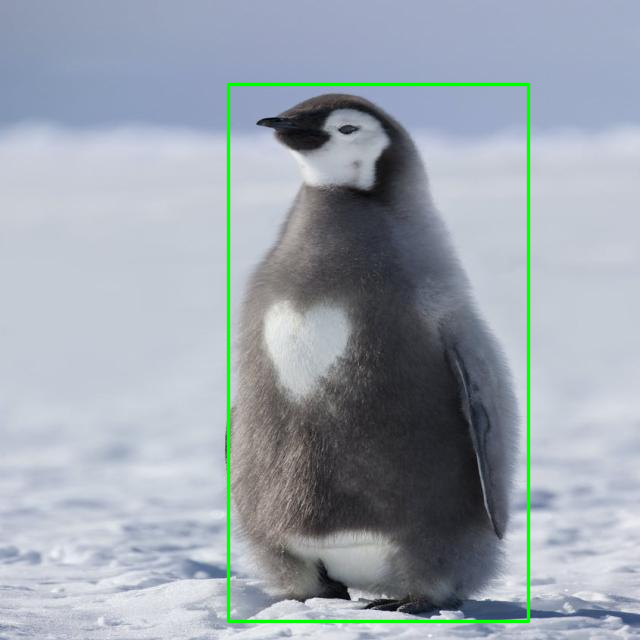

In [ ]:
# Example usage
image_path = os.path.join(ROOT_DIR, 'archive/valid/valid/image_id_000.jpg')

image = cv2.imread(image_path)

bounding_boxes = detection(image_path, model)

# Draw bounding boxes on the image
for (left, top, right, bottom) in bounding_boxes:
    start_point = (left, top)
    end_point = (right, bottom)
    color = (0, 255, 0)
    thickness = 2
    lineType = cv2.LINE_AA
    cv2.rectangle(image, start_point, end_point, color, thickness, lineType)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
!git clone https://github.com/DamnScallion/Visionary-Unicorns-Data.git

Cloning into 'Visionary-Unicorns-Data'...
remote: Enumerating objects: 582, done.
remote: Counting objects: 100% (582/582), done.
remote: Compressing objects: 100% (581/581), done.
remote: Total 582 (delta 1), reused 579 (delta 1), pack-reused 0
Receiving objects: 100% (582/582), 20.56 MiB | 34.91 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the first image and its corresponding bounding box
image_path = '/content/Visionary-Unicorns-Data/data/train/image_id_005.jpg'
image = cv2.imread(image_path)
train_file = '/content/Visionary-Unicorns-Data/data/train_annotations'
with open(train_file, 'r') as f:
    data = f.read()
annotation = pd.DataFrame(eval(data))
column_order = ["id", "image_id", "category_id", "bbox", "area", "segmentation", "iscrowd"]
annotation = annotation[column_order]
annotation_bboxes = annotation['bbox'].tolist()
bbox = annotation_bboxes[5]

In [ ]:
# Convert the bounding box to imgaug BoundingBoxesOnImage format
x1 = int(bbox[0])
y1 = int(bbox[1])
x2 = int(bbox[0]) + int(bbox[2])
y2 = int(bbox[1]) + int(bbox[3])
bounding_boxes = [BoundingBox(x1, y1, x2, y2)]

# Create an Augmenter object with desired augmentation techniques
augmenter = iaa.Sequential([
    iaa.Affine(
        rotate=(-10, 10),
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        shear=(-0.2, 0.2),
        scale=(0.8, 1.2)
    ),
    iaa.Fliplr(0.5),
])

# Convert image to imgaug format
image_aug = ia.imresize_single_image(image, (image.shape[1], image.shape[0]))

# Convert bounding boxes to imgaug format
bbs_aug = BoundingBoxesOnImage(bounding_boxes, shape=image.shape)

# Apply augmentation
image_aug, bbs_aug = augmenter(image=image_aug, bounding_boxes=bbs_aug)

print(f'bbs_aug = {bbs_aug}')

# Convert bounding boxes back to [x_min, y_min, x_max, y_max] format
augmented_bbox = bbs_aug.to_xyxy_array()[0]
augmented_bbox = list(augmented_bbox)

bbs_aug = BoundingBoxesOnImage([BoundingBox(x1=98.7359, y1=-25.2772, x2=588.4598, y2=485.5183, label=None)], shape=(640, 640, 3))


In [ ]:
augmented_bbox

[98.73588, -25.277174, 588.4598, 485.5183]

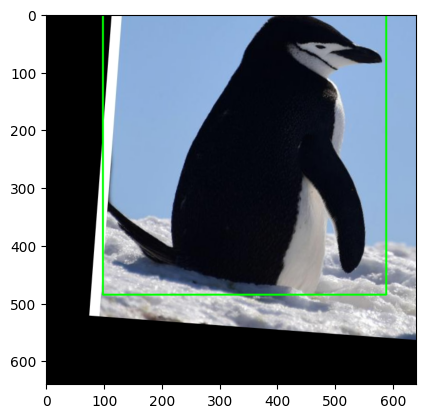

In [ ]:
x1, y1, x2, y2 = augmented_bbox
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

start_point = (x1, y1)
end_point = (x2, y2)
color = (0, 255, 0)
thickness = 2
lineType = cv2.LINE_AA
cv2.rectangle(image_aug, start_point, end_point, color, thickness, lineType)

plt.imshow(cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB))